#**SpaceX  Falcon 9 first stage Landing Prediction**

we will predict if the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch. In this lab, you will collect and make sure the data is in the correct format from an API. The following is an example of a successful and launch.

In [ ]:
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import sys
from bs4 import BeautifulSoup
import re
import unicodedata

import matplotlib.pyplot as plt
import seaborn as sns

import csv, sqlite3
import prettytable
prettytable.DEFAULT = 'DEFAULT'

con = sqlite3.connect("my_data1.db")
cur = con.cursor()

import folium



# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

Below we will define a series of helper functions that will help us use the API to extract information using identification numbers in the launch data.

From the rocket column we would like to learn the booster name.

From the <code>launchpad</code> we would like to know the name of the launch site being used, the logitude, and the latitude.


In [ ]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

In [ ]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to.



In [ ]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

In [ ]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

Now let's start requesting rocket launch data from SpaceX API with the following URL:


In [ ]:
spacex_url="https://api.spacexdata.com/v4/launches/past"

In [ ]:
response = requests.get(spacex_url)

In [ ]:
print(response.content)

b'[{"fairings":{"reused":false,"recovery_attempt":false,"recovered":false,"ships":[]},"links":{"patch":{"small":"https://images2.imgbox.com/94/f2/NN6Ph45r_o.png","large":"https://images2.imgbox.com/5b/02/QcxHUb5V_o.png"},"reddit":{"campaign":null,"launch":null,"media":null,"recovery":null},"flickr":{"small":[],"original":[]},"presskit":null,"webcast":"https://www.youtube.com/watch?v=0a_00nJ_Y88","youtube_id":"0a_00nJ_Y88","article":"https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html","wikipedia":"https://en.wikipedia.org/wiki/DemoSat"},"static_fire_date_utc":"2006-03-17T00:00:00.000Z","static_fire_date_unix":1142553600,"net":false,"window":0,"rocket":"5e9d0d95eda69955f709d1eb","success":false,"failures":[{"time":33,"altitude":null,"reason":"merlin engine failure"}],"details":"Engine failure at 33 seconds and loss of vehicle","crew":[],"ships":[],"capsules":[],"payloads":["5eb0e4b5b6c3bb0006eeb1e1"],"launchpad":"5e9e4502f5090995de566f86","flight_number":1,"name

##Request and parse the SpaceX launch data using the GET request

To make the requested JSON results more consistent, we will use the following static response object for this project:

In [ ]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

In [ ]:
response=requests.get(static_json_url)

In [ ]:
response.status_code

200

Now we decode the response content as a Json using .json() and turn it into a Pandas dataframe using .json_normalize()

In [ ]:
data = response.json()
data = pd.json_normalize(data)

In [ ]:
data.head(2)

,static_fire_date_utc,static_fire_date_unix,tbd,net,window,rocket,success,details,crew,ships,capsules,payloads,launchpad,auto_update,failures,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,True,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,https://images2.imgbox.com/40/e3/GypSkayF_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,False,"Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,True,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]",2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/4f/e3/I0lkuJ2e_o.png,https://images2.imgbox.com/be/e7/iNqsqVYM_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   static_fire_date_utc       100 non-null    object 
 1   static_fire_date_unix      100 non-null    float64
 2   tbd                        107 non-null    bool   
 3   net                        107 non-null    bool   
 4   window                     100 non-null    float64
 5   rocket                     107 non-null    object 
 6   success                    107 non-null    bool   
 7   details                    100 non-null    object 
 8   crew                       107 non-null    object 
 9   ships                      107 non-null    object 
 10  capsules                   107 non-null    object 
 11  payloads                   107 non-null    object 
 12  launchpad                  107 non-null    object 
 13  auto_update                107 non-null    bool   

In [ ]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['payloads', 'cores', 'id', 'rocket', 'launchpad', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

* From the <code>rocket</code> we would like to learn the booster name

* From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to

* From the <code>launchpad</code> we would like to know the name of the launch site being used, the longitude, and the latitude.

* **From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.**

The data from these requests will be stored in lists and will be used to create a new dataframe.


In [ ]:
#Global variables
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

These functions will apply the outputs globally to the above variables. Let's take a looks at <code>BoosterVersion</code> variable. Before we apply  <code>getBoosterVersion</code> the list is empty:


In [ ]:
BoosterVersion

[]

In [ ]:
# Call getBoosterVersion
getBoosterVersion(data)

In [ ]:
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

In [ ]:
# Call getLaunchSite
getLaunchSite(data)

In [ ]:
# Call getPayloadData
getPayloadData(data)

In [ ]:
# Call getCoreData
getCoreData(data)

Finally lets construct our dataset using the data we have obtained. We we combine the columns into a dictionary.


In [ ]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}


Then, we need to create a Pandas data frame from the dictionary launch_dict.


In [ ]:
df = pd.DataFrame(launch_dict)
display(df.head())

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


In [ ]:
df['BoosterVersion'].value_counts()

,count
BoosterVersion,
Falcon 9,90
Falcon 1,4


### Task 2: Filter the dataframe to only include `Falcon 9` launches


Finally we will remove the Falcon 1 launches keeping only the Falcon 9 launches. Filter the data dataframe using the BoosterVersion column to only keep the Falcon 9 launches. Save the filtered data to a new dataframe called data_falcon9.

In [ ]:
data_falcon9 = df[df['BoosterVersion'] == "Falcon 9"]
display(data_falcon9.head())

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [ ]:
data_falcon9.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 4 to 93
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    90 non-null     int64  
 1   Date            90 non-null     object 
 2   BoosterVersion  90 non-null     object 
 3   PayloadMass     85 non-null     float64
 4   Orbit           90 non-null     object 
 5   LaunchSite      90 non-null     object 
 6   Outcome         90 non-null     object 
 7   Flights         90 non-null     int64  
 8   GridFins        90 non-null     bool   
 9   Reused          90 non-null     bool   
 10  Legs            90 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     90 non-null     int64  
 14  Serial          90 non-null     object 
 15  Longitude       90 non-null     float64
 16  Latitude        90 non-null     float64
dtypes: bool(3), float64(4), int64(3), object(7

Now that we have removed some values we should reset the FlgihtNumber column

In [ ]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))

In [ ]:
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


In [ ]:
data_falcon9.isnull().sum()

,0
FlightNumber,0
Date,0
BoosterVersion,0
PayloadMass,5
Orbit,0
LaunchSite,0
Outcome,0
Flights,0
GridFins,0
Reused,0


Task 3: Dealing with Missing Values

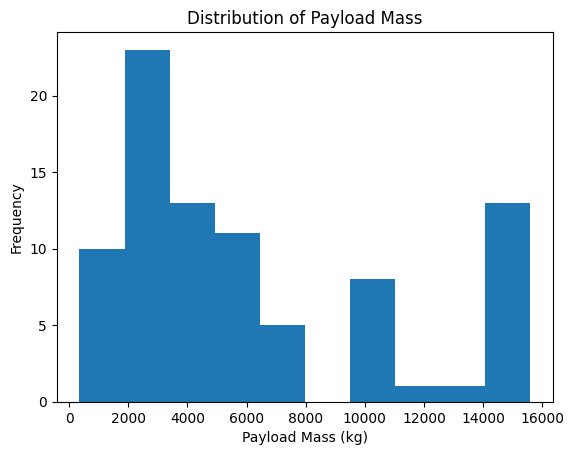

In [ ]:
plt.hist(data_falcon9['PayloadMass'])
plt.xlabel('Payload Mass (kg)')
plt.ylabel('Frequency')
plt.title('Distribution of Payload Mass')
plt.show()

In [ ]:
#compute the mean for the PayloadMass and replace those missing values

meandata = data_falcon9['PayloadMass'].mean()
data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].fillna(meandata)

/tmp/ipython-input-3987575485.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].fillna(meandata)


In [ ]:
data_falcon9.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 4 to 93
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    90 non-null     int64  
 1   Date            90 non-null     object 
 2   BoosterVersion  90 non-null     object 
 3   PayloadMass     90 non-null     float64
 4   Orbit           90 non-null     object 
 5   LaunchSite      90 non-null     object 
 6   Outcome         90 non-null     object 
 7   Flights         90 non-null     int64  
 8   GridFins        90 non-null     bool   
 9   Reused          90 non-null     bool   
 10  Legs            90 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     90 non-null     int64  
 14  Serial          90 non-null     object 
 15  Longitude       90 non-null     float64
 16  Latitude        90 non-null     float64
dtypes: bool(3), float64(4), int64(3), object(7

In [ ]:
data_falcon9.to_csv('dataset_part_1.csv', index=False)

In [ ]:
import sys

import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

In [ ]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()

    colunm_name = ' '.join(row.contents)

    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name


To keep the lab tasks consistent, you will be asked to scrape the data from a snapshot of the  `List of Falcon 9 and Falcon Heavy launches` Wikipage updated on
`9th June 2021`

In [ ]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

headers = {
    "User-Agent": "MiScrapperProyecto/1.0 (davidzamudiotab@gmail.com)"
}

# Realizar la petición
response = requests.get(static_url, headers=headers)

# Verificar el código de estado
print(response.status_code) # Debería ser 200 si tiene éxito

if response.status_code == 200:
    # Continuar con tu código de Beautiful Soup o procesamiento
    print("Petición exitosa, puedes hacer el scraping.")
else:
    print(f"Error: {response.status_code}")

200
Petición exitosa, puedes hacer el scraping.


### TASK 1: Request the Falcon9 Launch Wiki page from its URL

"""First, let's perform an HTTP GET method to request the Falcon9 Launch HTML page, as an HTTP response."""

In [ ]:
soup = BeautifulSoup(response.content, 'html.parser')

In [ ]:
# Use the find_all function in the BeautifulSoup object, with element type `table`
# Assign the result to a list called `html_tables`
html_tables = soup.find_all('table')

In [ ]:
html_tables

[<table class="col-begin" role="presentation">
 <tbody><tr>
 <td class="col-break">
 <div class="mw-heading mw-heading3"><h3 id="Rocket_configurations">Rocket configurations</h3></div>
 <div class="chart noresize" style="padding-top:10px;margin-top:1em;max-width:420px;">
 <div style="position:relative;min-height:320px;min-width:420px;max-width:420px;">
 <div style="float:right;position:relative;min-height:240px;min-width:320px;max-width:320px;border-left:1px black solid;border-bottom:1px black solid;">
 <div style="position:absolute;left:3px;top:224px;height:15px;min-width:18px;max-width:18px;color:inherit;background-color:LightSteelBlue;-webkit-print-color-adjust:exact;border:1px solid LightSteelBlue;border-bottom:none;overflow:hidden;" title="[[Falcon 9 v1.0]]: 2"></div>
 <div style="position:absolute;left:55px;top:224px;height:15px;min-width:18px;max-width:18px;color:inherit;background-color:LightSteelBlue;-webkit-print-color-adjust:exact;border:1px solid LightSteelBlue;border-botto

In [ ]:
# Let's print the first table and check its content
first_launch_table = html_tables[2]
print(first_launch_table)

<table class="wikitable plainrowheaders collapsible" style="width: 100%;">
<tbody><tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11"><span class="cite-bracket">[</span>b<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12"><span class="cite-bracket">[</span>c<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 

In [ ]:
column_names = []

# Apply find_all() function with `th` element on first_launch_table


# Iterate each th element and apply the provided extract_column_from_header() to get a column name

# Append the Non-empty column name (`if name is not None and len(name) > 0`) into a list called column_names

In [ ]:
column_names = []
# Apply find_all() function with `th` element on first_launch_table
th_elements = first_launch_table.find_all('th')

# Iterate each th element and apply the provided extract_column_from_header() to get a column name
for th in th_elements:
    name = extract_column_from_header(th)
    # Append the Non-empty column name (`if name is not None and len(name) > 0`) into a list called column_names
    if name is not None and len(name) > 0:
        column_names.append(name)

print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


TASK 3: Create a data frame by parsing the launch HTML tables
We will create an empty dictionary with keys from the extracted column names in the previous task. Later, this dictionary will be converted into a Pandas dataframe

In [ ]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

Next, we just need to fill up the `launch_dict` with launch records extracted from table rows.


Usually, HTML tables in Wiki pages are likely to contain unexpected annotations and other types of noises, such as reference links `B0004.1[8]`, missing values `N/A [e]`, inconsistent formatting, etc.

To simplify the parsing process, we have provided an incomplete code snippet below to help you to fill up the `launch_dict`. Please complete the following code snippet with TODOs or you can choose to write your own logic to parse all launch tables:


In [ ]:
extracted_row = 0
#Extract each table
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit() # will return flag = True if the table header is a digit
        else:
            flag=False
        #get table element
        row=rows.find_all('td')
        #if it is number save cells in a dictonary
        if flag: # if the row happens to be a flagged row since it is a digit
            extracted_row += 1 # will add one row
            # Flight Number value
            # TODO: Append the flight_number into launch_dict with key `Flight No.`
            launch_dict['Flight No.'].append(flight_number)
            #print(flight_number)
            try:
                datatimelist=date_time(row[0])
                # Date value
                # TODO: Append the date into launch_dict with key `Date`
                date = datatimelist[0].strip(',')
                launch_dict['Date'].append(date)
                #print(date)

                # Time value
                # TODO: Append the time into launch_dict with key `Time`
                time = datatimelist[1]
                launch_dict['Time'].append(time)
                #print(time)
            except IndexError:
                launch_dict['Date'].append(None)
                launch_dict['Time'].append(None)
                print(f"Error processing date/time for row {extracted_row}: {row}")


            # Booster version
            # TODO: Append the bv into launch_dict with key `Version Booster`
            try:
                bv=booster_version(row[1])
                if not(bv):
                    bv=row[1].a.string
                launch_dict['Version Booster'].append(bv)
                #print(bv)
            except (IndexError, AttributeError):
                launch_dict['Version Booster'].append(None)
                print(f"Error processing booster version for row {extracted_row}: {row}")


            # Launch Site
            # TODO: Append the bv into launch_dict with key `Launch Site`
            try:
                launch_site = row[2].a.string
                launch_dict['Launch site'].append(launch_site)
                #print(launch_site)
            except (IndexError, AttributeError):
                launch_dict['Launch site'].append(None)
                print(f"Error processing launch site for row {extracted_row}: {row}")


            # Payload
            # TODO: Append the payload into launch_dict with key `Payload`
            try:
                payload = row[3].a.string
                launch_dict['Payload'].append(payload)
                #print(payload)
            except (IndexError, AttributeError):
                launch_dict['Payload'].append(None)
                print(f"Error processing payload for row {extracted_row}: {row}")

            # Payload Mass
            # TODO: Append the payload_mass into launch_dict with key `Payload mass`
            try:
                payload_mass = get_mass(row[4])
                launch_dict['Payload mass'].append(payload_mass)
                #print(payload)
            except (IndexError, AttributeError):
                launch_dict['Payload mass'].append(None)
                print(f"Error processing payload mass for row {extracted_row}: {row}")


            # Orbit
            # TODO: Append the orbit into launch_dict with key `Orbit`
            try:
                orbit = row[5].a.string
                launch_dict['Orbit'].append(orbit)
                #print(orbit)
            except (IndexError, AttributeError):
                launch_dict['Orbit'].append(None)
                print(f"Error processing orbit for row {extracted_row}: {row}")


            # Customer
            # TODO: Append the customer into launch_dict with key `Customer`
            try:
                customer = row[6].a.string
                launch_dict['Customer'].append(customer)
                #print(customer)
            except (IndexError, AttributeError):
                # Some rows have multiple customers in a plainlist, handle this case
                customer_list = row[6].find_all('li')
                if customer_list:
                    customers = [cust.text.strip() for cust in customer_list]
                    launch_dict['Customer'].append(', '.join(customers))
                else:
                    launch_dict['Customer'].append(None)
                    print(f"Error processing customer for row {extracted_row}: {row}")


            # Launch outcome
            # TODO: Append the launch_outcome into launch_dict with key `Launch outcome`
            try:
                launch_outcome = list(row[7].strings)[0]
                launch_dict['Launch outcome'].append(launch_outcome)
                #print(launch_outcome)
            except (IndexError, AttributeError):
                launch_dict['Launch outcome'].append(None)
                print(f"Error processing launch outcome for row {extracted_row}: {row}")


            # Booster landing
            # TODO: Append the launch_outcome into launch_dict with key `Booster landing`
            try:
                booster_landing = landing_status(row[8])
                launch_dict['Booster landing'].append(booster_landing)
                #print(booster_landing)
            except (IndexError, AttributeError):
                launch_dict['Booster landing'].append(None)
                print(f"Error processing booster landing for row {extracted_row}: {row}")


#After you have fill in the parsed launch record values into `launch_dict`, you can create a dataframe from it.

Error processing customer for row 106: [<td>24 January 2021<br/>15:00<sup class="reference" id="cite_ref-624"><a href="#cite_note-624"><span class="cite-bracket">[</span>612<span class="cite-bracket">]</span></a></sup>
</td>, <td><a href="/wiki/Falcon_9_Block_5" title="Falcon 9 Block 5">F9 B5</a> ♺<br/><a href="/wiki/List_of_Falcon_9_first-stage_boosters#B1058" title="List of Falcon 9 first-stage boosters">B1058.5</a><sup class="reference" id="cite_ref-625"><a href="#cite_note-625"><span class="cite-bracket">[</span>613<span class="cite-bracket">]</span></a></sup>
</td>, <td><a href="/wiki/Cape_Canaveral_Space_Force_Station" title="Cape Canaveral Space Force Station">CCSFS</a>,<br/><a href="/wiki/Cape_Canaveral_Space_Launch_Complex_40" title="Cape Canaveral Space Launch Complex 40">SLC-40</a>
</td>, <td><i><a class="new" href="/w/index.php?title=Transporter-1&amp;action=edit&amp;redlink=1" title="Transporter-1 (page does not exist)">Transporter-1</a></i> (<a href="/wiki/List_of_spacefl

In [ ]:
df= pd.DataFrame({ key:pd.Series(value) for key, value in launch_dict.items() })

In [ ]:
df.to_csv('spacex_web_scraped.csv', index=False)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94 entries, 0 to 105
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   payloads       94 non-null     object
 1   cores          94 non-null     object
 2   id             94 non-null     object
 3   rocket         94 non-null     object
 4   launchpad      94 non-null     object
 5   flight_number  94 non-null     int64 
 6   date_utc       94 non-null     object
 7   date           94 non-null     object
dtypes: int64(1), object(7)
memory usage: 6.6+ KB


In [ ]:
soup.title

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>

Lab 2: Data wrangling
Estimated time needed: 60 minutes

In this lab, we will perform some Exploratory Data Analysis (EDA) to find some patterns in the data and determine what would be the label for training supervised models.

In the data set, there are several different cases where the booster did not land successfully. Sometimes a landing was attempted but failed due to an accident; for example, True Ocean means the mission outcome was successfully landed to a specific region of the ocean while False Ocean means the mission outcome was unsuccessfully landed to a specific region of the ocean. True RTLS means the mission outcome was successfully landed to a ground pad False RTLS means the mission outcome was unsuccessfully landed to a ground pad.True ASDS means the mission outcome was successfully landed on a drone ship False ASDS means the mission outcome was unsuccessfully landed on a drone ship.

In this lab we will mainly convert those outcomes into Training Labels with 1 means the booster successfully landed 0 means it was unsuccessful.







Falcon 9 first stage will land successfully

In [ ]:
df=pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv")
df.head(10)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857
5,6,2014-01-06,Falcon 9,3325.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1005,-80.577366,28.561857
6,7,2014-04-18,Falcon 9,2296.000000,ISS,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1006,-80.577366,28.561857
7,8,2014-07-14,Falcon 9,1316.000000,LEO,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1007,-80.577366,28.561857
8,9,2014-08-05,Falcon 9,4535.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1008,-80.577366,28.561857
9,10,2014-09-07,Falcon 9,4428.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1011,-80.577366,28.561857


In [ ]:
df.dtypes

,0
FlightNumber,int64
Date,object
BoosterVersion,object
PayloadMass,float64
Orbit,object
LaunchSite,object
Outcome,object
Flights,int64
GridFins,bool
Reused,bool


In [ ]:
df['LaunchSite'].value_counts()

,count
LaunchSite,
CCAFS SLC 40,55
KSC LC 39A,22
VAFB SLC 4E,13


* <b>LEO</b>: Low Earth orbit (LEO)is an Earth-centred orbit with an altitude of 2,000 km (1,200 mi) or less (approximately one-third of the radius of Earth),[1] or with at least 11.25 periods per day (an orbital period of 128 minutes or less) and an eccentricity less than 0.25.[2] Most of the manmade objects in outer space are in LEO <a href='https://en.wikipedia.org/wiki/Low_Earth_orbit'>[1]</a>.

* <b>VLEO</b>: Very Low Earth Orbits (VLEO) can be defined as the orbits with a mean altitude below 450 km. Operating in these orbits can provide a number of benefits to Earth observation spacecraft as the spacecraft operates closer to the observation<a href='https://www.researchgate.net/publication/271499606_Very_Low_Earth_Orbit_mission_concepts_for_Earth_Observation_Benefits_and_challenges'>[2]</a>.


* <b>GTO</b>(Geostationary Transfer Orbit): A geostationary transfer orbit is an elliptical Earth orbit used to transfer satellites from low Earth orbit (LEO) to geostationary orbit (GEO). In a GTO, the perigee (closest point to Earth) is much lower than GEO altitude, while the apogee (farthest point) reaches approximately 22,236 miles (35,786 kilometers) above Earth’s equator — the altitude of a geostationary orbit. Satellites in GTO use onboard propulsion to circularize their orbit at GEO altitude, where they can provide services such as weather monitoring, communications, and surveillance. <a  href="https://www.space.com/29222-geosynchronous-orbit.html" >[3] </a>.


* <b>SSO (or SO)</b>: It is a Sun-synchronous orbit  also called a heliosynchronous orbit is a nearly polar orbit around a planet, in which the satellite passes over any given point of the planet's surface at the same local mean solar time <a href="https://en.wikipedia.org/wiki/Sun-synchronous_orbit">[4] <a>.
    
    
    
* <b>ES-L1 </b>:At the Lagrange points the gravitational forces of the two large bodies cancel out in such a way that a small object placed in orbit there is in equilibrium relative to the center of mass of the large bodies. L1 is one such point between the sun and the earth <a href="https://en.wikipedia.org/wiki/Lagrange_point#L1_point">[5]</a> .
    
    
* <b>HEO</b> A highly elliptical orbit, is an elliptic orbit with high eccentricity, usually referring to one around Earth <a href="https://en.wikipedia.org/wiki/Highly_elliptical_orbit">[6]</a>.


* <b> ISS </b> A modular space station (habitable artificial satellite) in low Earth orbit. It is a multinational collaborative project between five participating space agencies: NASA (United States), Roscosmos (Russia), JAXA (Japan), ESA (Europe), and CSA (Canada)<a href="https://en.wikipedia.org/wiki/International_Space_Station"> [7] </a>


* <b> MEO </b> Geocentric orbits ranging in altitude from 2,000 km (1,200 mi) to just below geosynchronous orbit at 35,786 kilometers (22,236 mi). Also known as an intermediate circular orbit. These are "most commonly at 20,200 kilometers (12,600 mi), or 20,650 kilometers (12,830 mi), with an orbital period of 12 hours <a href="https://en.wikipedia.org/wiki/List_of_orbits"> [8] </a>


* <b> HEO </b> Geocentric orbits above the altitude of geosynchronous orbit (35,786 km or 22,236 mi) <a href="https://en.wikipedia.org/wiki/List_of_orbits"> [9] </a>


* <b> GEO </b> It is a circular geosynchronous orbit 35,786 kilometres (22,236 miles) above Earth's equator and following the direction of Earth's rotation <a href="https://en.wikipedia.org/wiki/Geostationary_orbit"> [10] </a>


* <b> PO </b> It is one type of satellites in which a satellite passes above or nearly above both poles of the body being orbited (usually a planet such as the Earth <a href="https://en.wikipedia.org/wiki/Polar_orbit"> [11] </a>

some are shown in the following plot:

In [ ]:
df['Orbit'].value_counts()

,count
Orbit,
GTO,27
ISS,21
VLEO,14
PO,9
LEO,7
SSO,5
MEO,3
HEO,1
ES-L1,1


In [ ]:
landing_outcomes = df['Outcome'].value_counts()
landing_outcomes

,count
Outcome,
True ASDS,41
None None,19
True RTLS,14
False ASDS,6
True Ocean,5
False Ocean,2
None ASDS,2
False RTLS,1


<code>True Ocean</code> means the mission outcome was successfully  landed to a specific region of the ocean while <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean. <code>True RTLS</code> means the mission outcome was successfully  landed to a ground pad <code>False RTLS</code> means the mission outcome was unsuccessfully landed to a ground pad.<code>True ASDS</code> means the mission outcome was successfully  landed to a drone ship <code>False ASDS</code> means the mission outcome was unsuccessfully landed to a drone ship. <code>None ASDS</code> and <code>None None</code> these represent a failure to land.


In [ ]:
for i, outcomes in enumerate (landing_outcomes.keys()):
  print(i,outcomes)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


We create a set of outcomes where the second stage did not land successfully:

In [ ]:
bad_outcomes = set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [ ]:
landing_class = [0 if outcome in bad_outcomes else 1 for outcome in df['Outcome']]
df['Class'] = landing_class

In [ ]:
df[['Class']].head(8)

,Class
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,1


In [ ]:
df['Class'].mean()

np.float64(0.6666666666666666)

In [ ]:
df.to_csv("dataset_part_2.csv", index=False)

In [ ]:
df['Class'].value_counts()

,count
Class,
1,60
0,30


# DATA WRANGLING

In [ ]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [ ]:
%sql sqlite:///my_data1.db

In [ ]:
import pandas as pd
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False,method="multi")

101

In [ ]:
%sql create table SPACEXTABLE as select * from SPACEXTBL where Date is not null

 * sqlite:///my_data1.db
(sqlite3.OperationalError) table SPACEXTABLE already exists
[SQL: create table SPACEXTABLE as select * from SPACEXTBL where Date is not null]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [ ]:
%sql SELECT * FROM SPACEXTABLE LIMIT 10;

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt
2013-09-29,16:00:00,F9 v1.1 B1003,VAFB SLC-4E,CASSIOPE,500,Polar LEO,MDA,Success,Uncontrolled (ocean)
2013-12-03,22:41:00,F9 v1.1,CCAFS LC-40,SES-8,3170,GTO,SES,Success,No attempt
2014-01-06,22:06:00,F9 v1.1,CCAFS LC-40,Thaicom 6,3325,GTO,Thaicom,Success,No attempt
2014-04-18,19:25:00,F9 v1.1,CCAFS LC-40,SpaceX CRS-3,2296,LEO (ISS),NASA (CRS),Success,Controlled (ocean)
2014-07-14,15:15:00,F9 v1.1,CCAFS LC-40,OG2 Mission 1 6 Orbcomm-OG2 satellites,1316,LEO,Orbcomm,Success,Controlled (ocean)


Display the names of the unique launch sites in the space mission

In [ ]:
%sql SELECT DISTINCT Launch_Site FROM SPACEXTABLE

 * sqlite:///my_data1.db
Done.


Launch_Site
CCAFS LC-40
VAFB SLC-4E
KSC LC-39A
CCAFS SLC-40


:Task 2
Display 5 records where launch sites begin with the string 'CCA'

In [ ]:
%sql SELECT * FROM SPACEXTABLE WHERE Launch_Site LIKE 'CCA%' LIMIT 5;

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


Task 3
Display the total payload mass carried by boosters launched by NASA (CRS)

In [ ]:
%sql SELECT SUM (PAYLOAD_MASS__KG_) AS Total_Mass FROM SPACEXTABLE WHERE Customer = 'NASA (CRS)'

 * sqlite:///my_data1.db
Done.


Total_Mass
45596


Task 4
Display average payload mass carried by booster version F9 v1.1

In [ ]:
%sql SELECT AVG (PAYLOAD_MASS__KG_) AS Averege_Mass_BB FROM SPACEXTABLE WHERE Booster_Version LIKE 'F9 v1.1%' ;

 * sqlite:///my_data1.db
Done.


Averege_Mass_BB
2534.6666666666665


Task 5
List the date when the first succesful landing outcome in ground pad was acheived.
Hint:Use min function

In [ ]:
%sql SELECT DISTINCT Landing_Outcome FROM SPACEXTABLE;

 * sqlite:///my_data1.db
Done.


Landing_Outcome
Failure (parachute)
No attempt
Uncontrolled (ocean)
Controlled (ocean)
Failure (drone ship)
Precluded (drone ship)
Success (ground pad)
Success (drone ship)
Success
Failure


In [ ]:
%sql SELECT MIN (Date) FROM SPACEXTABLE WHERE Landing_Outcome = 'Success (ground pad)'

 * sqlite:///my_data1.db
Done.


MIN (Date)
2015-12-22


Task 6
List the names of the boosters which have success in drone ship and have payload mass greater than 4000 but less than 6000

In [ ]:
%sql SELECT DISTINCT Booster_Version FROM SPACEXTABLE WHERE Landing_Outcome = 'Success (drone ship)' AND PAYLOAD_MASS__KG_ BETWEEN 4000 AND 6000;

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 FT B1022
F9 FT B1026
F9 FT B1021.2
F9 FT B1031.2


Task 7
List the total number of successful and failure mission outcomes

In [ ]:
%sql SELECT Mission_Outcome, COUNT(*) AS Total FROM SPACEXTABLE GROUP BY Mission_Outcome;

 * sqlite:///my_data1.db
Done.


Mission_Outcome,Total
Failure (in flight),1
Success,98
Success,1
Success (payload status unclear),1


Task 8
List all the booster_versions that have carried the maximum payload mass, using a subquery with a suitable aggregate function.

---



In [ ]:
%sql SELECT Booster_Version FROM SPACEXTABLE WHERE PAYLOAD_MASS__KG_ = (SELECT MAX(PAYLOAD_MASS__KG_) FROM SPACEXTABLE);

 * sqlite:///my_data1.db
Done.


Booster_Version
F9 B5 B1048.4
F9 B5 B1049.4
F9 B5 B1051.3
F9 B5 B1056.4
F9 B5 B1048.5
F9 B5 B1051.4
F9 B5 B1049.5
F9 B5 B1060.2
F9 B5 B1058.3
F9 B5 B1051.6


Task 9
List the records which will display the month names, failure landing_outcomes in drone ship ,booster versions, launch_site for the months in year 2015.
Note: SQLLite does not support monthnames. So you need to use substr(Date, 6,2) as month to get the months and substr(Date,0,5)='2015' for year.

In [ ]:
%sql SELECT substr(Date, 6, 2) AS Month_of_2015 , Booster_Version, Launch_Site FROM SPACEXTABLE WHERE Landing_Outcome = 'Failure (drone ship)' AND substr(Date, 0, 5) = '2015';

 * sqlite:///my_data1.db
Done.


Month_of_2015,Booster_Version,Launch_Site
01,F9 v1.1 B1012,CCAFS LC-40
04,F9 v1.1 B1015,CCAFS LC-40


Task 10
Rank the count of landing outcomes (such as Failure (drone ship) or Success (ground pad)) between the date 2010-06-04 and 2017-03-20, in descending order.

In [ ]:
%sql SELECT Landing_Outcome, COUNT(*) AS OutcomeCount FROM SPACEXTABLE WHERE Date BETWEEN '2010-06-04' AND '2017-03-20' GROUP BY Landing_Outcome ORDER BY OutcomeCount DESC;

 * sqlite:///my_data1.db
Done.


Landing_Outcome,OutcomeCount
No attempt,10
Success (drone ship),5
Failure (drone ship),5
Success (ground pad),3
Controlled (ocean),3
Uncontrolled (ocean),2
Failure (parachute),2
Precluded (drone ship),1


In [ ]:
%sql SELECT MIN(PAYLOAD_MASS__KG_) FROM SPACEXTABLE;

 * sqlite:///my_data1.db
Done.


MIN(PAYLOAD_MASS__KG_)
0


Exploratory Data Analysis

In [ ]:
import requests
import io

URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp = requests.get(URL)
dataset_part_2_csv = io.BytesIO(resp.content)
df=pd.read_csv(dataset_part_2_csv)
display(df.head(5))

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


First, let's try to see how the FlightNumber (indicating the continuous launch attempts.) and Payload variables would affect the launch outcome.

We can plot out the FlightNumber vs. PayloadMassand overlay the outcome of the launch. We see that as the flight number increases, the first stage is more likely to land successfully. The payload mass also appears to be a factor; even with more massive payloads, the first stage often returns successfully.

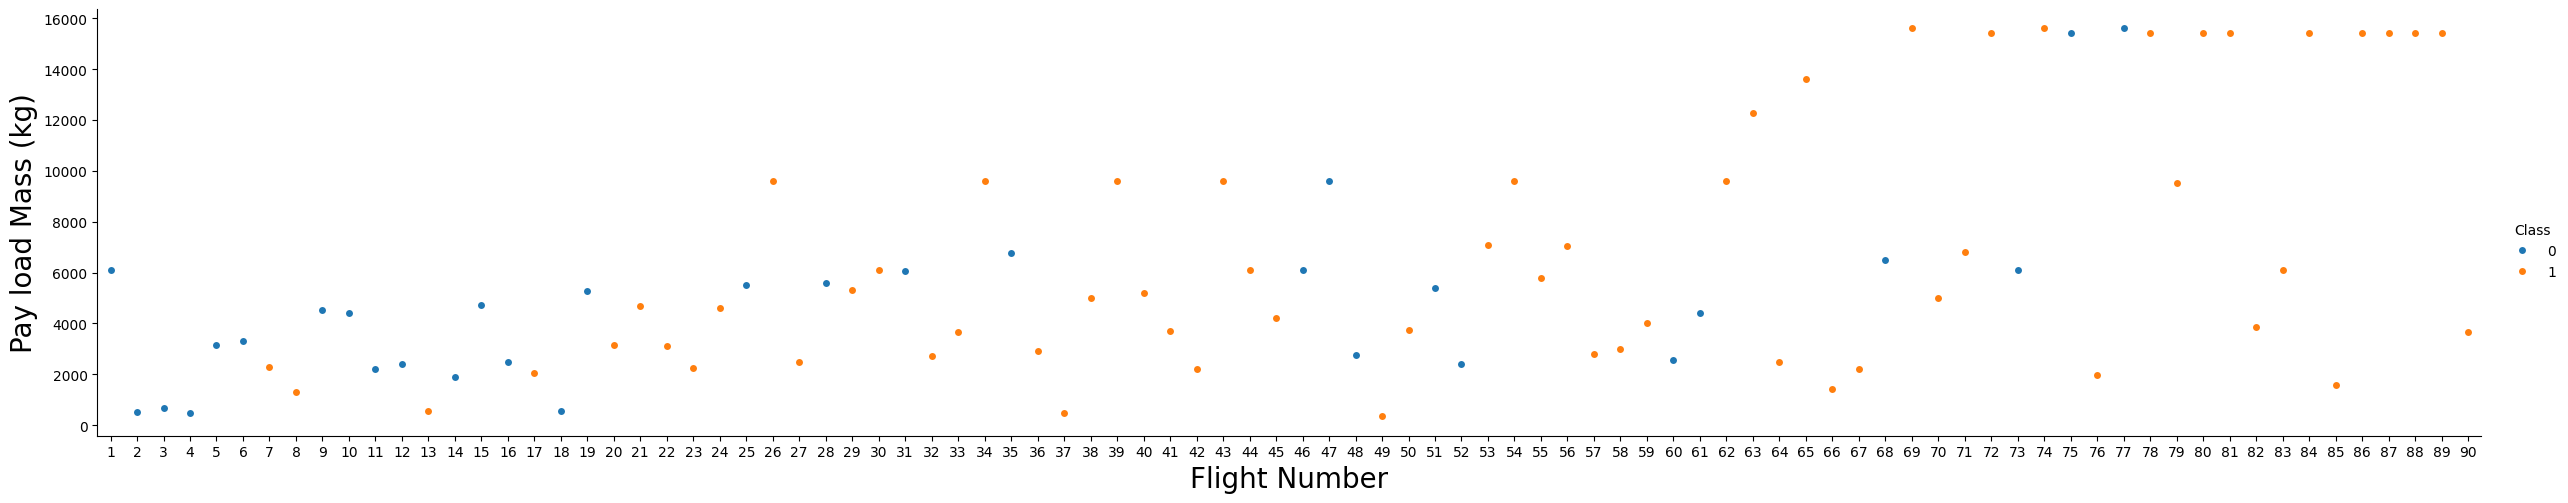

In [ ]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

### TASK 1: Visualize the relationship between Flight Number and Launch Site

Use the function catplot to plot FlightNumber vs LaunchSite, set the parameter x parameter to FlightNumber,set the y to Launch Site and set the parameter hue to 'class'

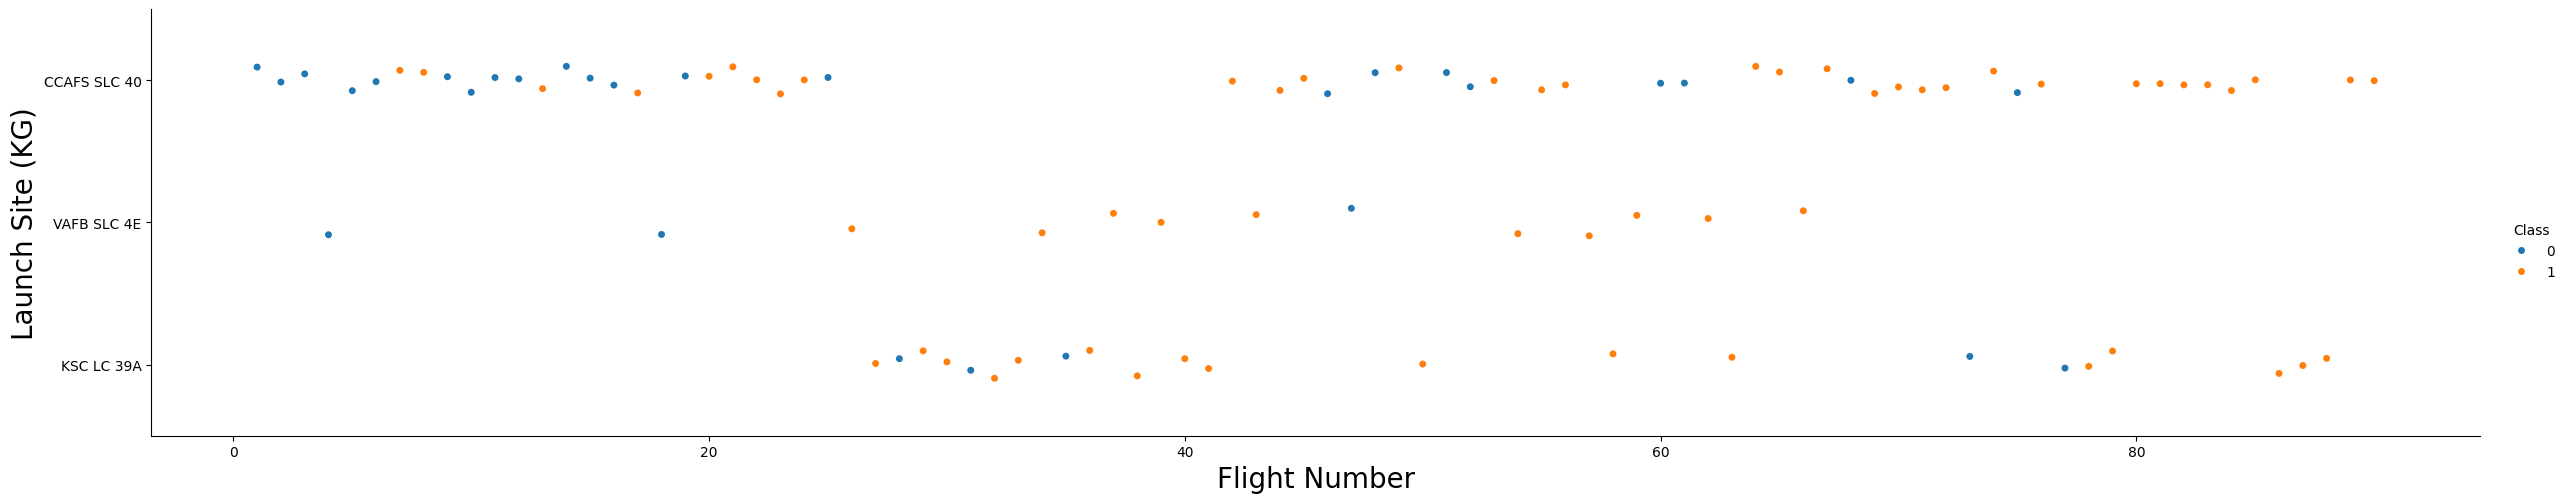

In [ ]:
sns.catplot(x = 'FlightNumber', y= 'LaunchSite', data=df, hue="Class", aspect = 5)
plt.xlabel("Flight Number", fontsize = 20)
plt.ylabel("Launch Site (KG)", fontsize = 20)
plt.show()

### TASK 2: Visualize the relationship between Payload Mass and Launch Site
We also want to observe if there is any relationship between launch sites and their payload mass.


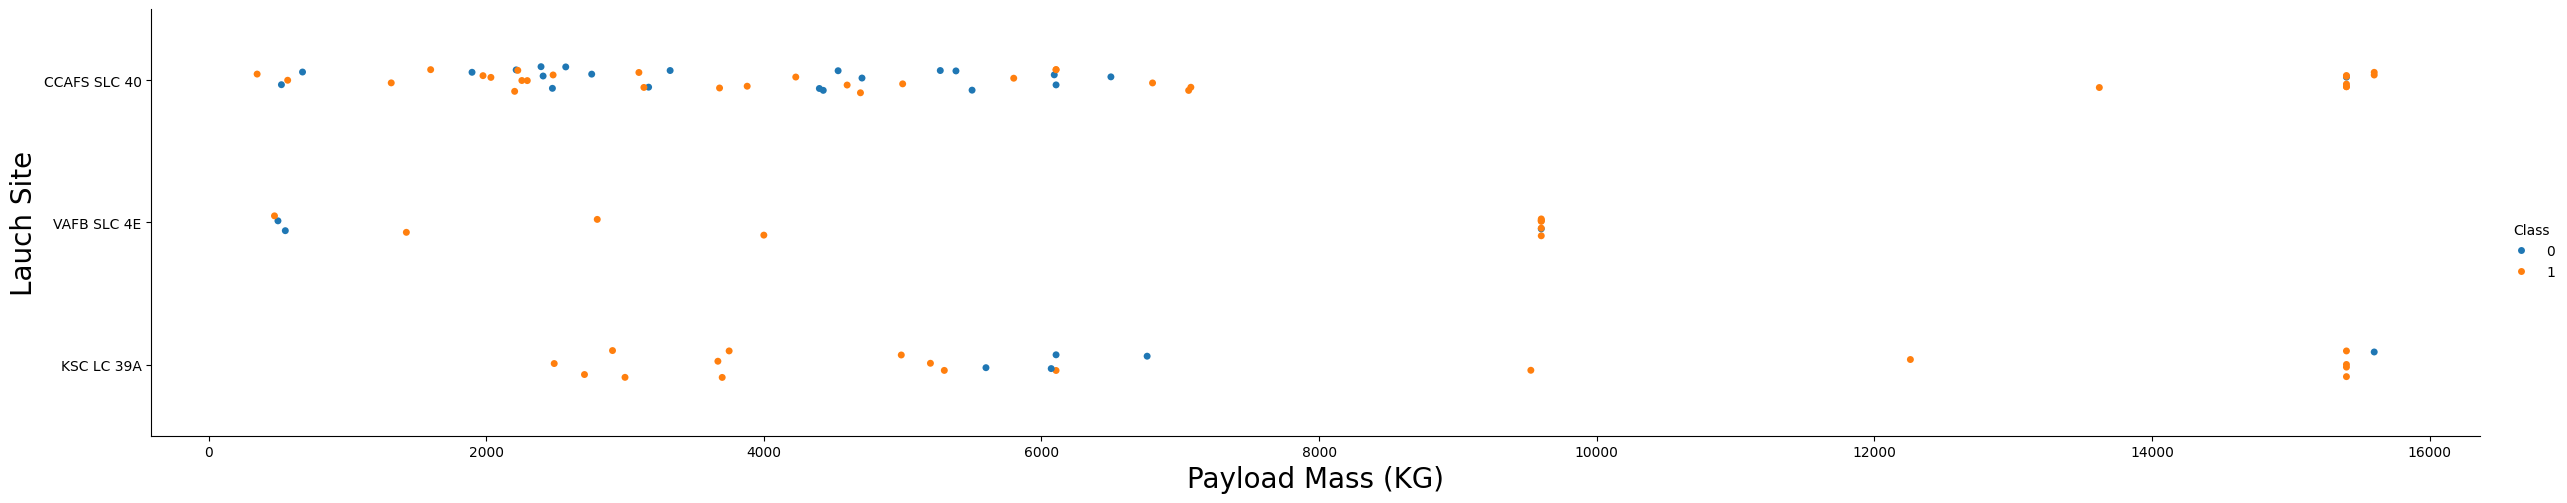

In [ ]:
sns.catplot( x = 'PayloadMass', y = 'LaunchSite', data = df, hue = "Class", aspect = 5)
plt.xlabel("Payload Mass (KG)", fontsize = 20)
plt.ylabel("Lauch Site", fontsize = 20)
plt.show()

TASK 3: Visualize the relationship between success rate of each orbit type

In [ ]:
succbyorbit = df.groupby('Orbit')['Class'].mean().reset_index()

Text(0, 0.5, 'Success rate')

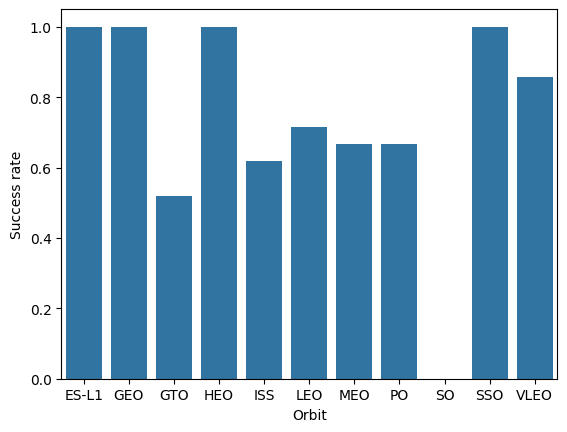

In [ ]:
sns.barplot( x = 'Orbit', y=  'Class', data = succbyorbit)
plt.ylabel("Success rate")

In [ ]:
succbyorbit

,Orbit,Class
0,ES-L1,1.000000
1,GEO,1.000000
2,GTO,0.518519
3,HEO,1.000000
4,ISS,0.619048
5,LEO,0.714286
6,MEO,0.666667
7,PO,0.666667
8,SO,0.000000
9,SSO,1.000000


TASK 4: Visualize the relationship between FlightNumber and Orbit type
For each orbit, we want to see if there is any relationship between FlightNumber and Orbit type.

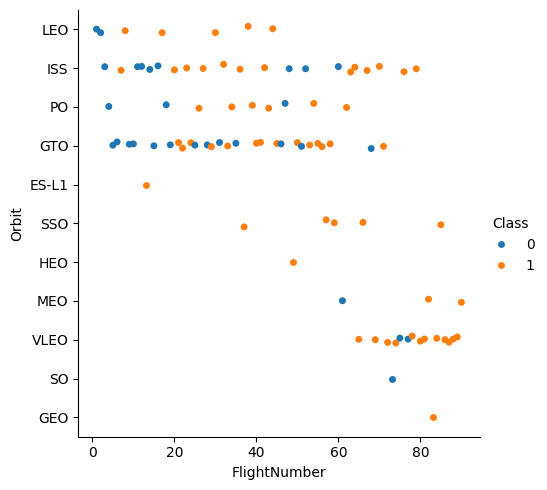

In [ ]:
sns.catplot( data = df, x = 'FlightNumber', y = 'Orbit', hue = 'Class')

You can observe that in the LEO orbit, success seems to be related to the number of flights. Conversely, in the GTO orbit, there appears to be no relationship between flight number and success.

###TASK 5: Visualize the relationship between Payload Mass and Orbit type
Similarly, we can plot the Payload Mass vs. Orbit scatter point charts to reveal the relationship between Payload Mass and Orbit type

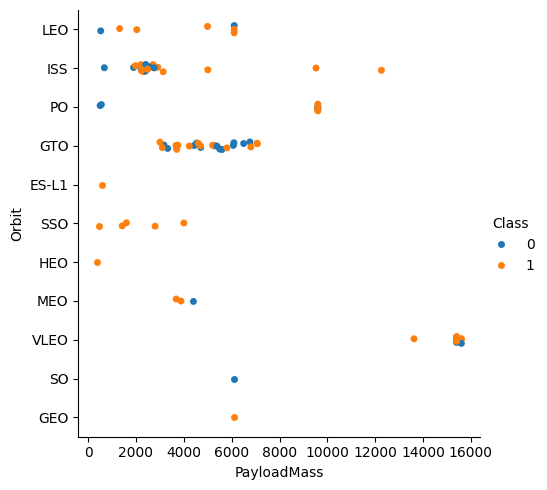

In [ ]:
sns.catplot( data = df, x = 'PayloadMass', y = 'Orbit', hue = 'Class')

With heavy payloads the successful landing or positive landing rate are more for Polar,LEO and ISS.

However, for GTO, it's difficult to distinguish between successful and unsuccessful landings as both outcomes are present.

TASK 6: Visualize the launch success yearly trend
You can plot a line chart with x axis to be Year and y axis to be average success rate, to get the average launch success trend.







The function will help you get the year from the date:

In [ ]:
# A function to Extract years from the date
year=[]
def Extract_year():
    for i in df["Date"]:
        year.append(i.split("-")[0])
    return year
Extract_year()
df['Date'] = year
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [ ]:
df.groupby('Date')['Class'].mean().reset_index()

,Date,Class
0,2010,0.000000
1,2012,0.000000
2,2013,0.000000
3,2014,0.333333
4,2015,0.333333
5,2016,0.625000
6,2017,0.833333
7,2018,0.611111
8,2019,0.900000
9,2020,0.842105


<Axes: xlabel='Date', ylabel='Class'>

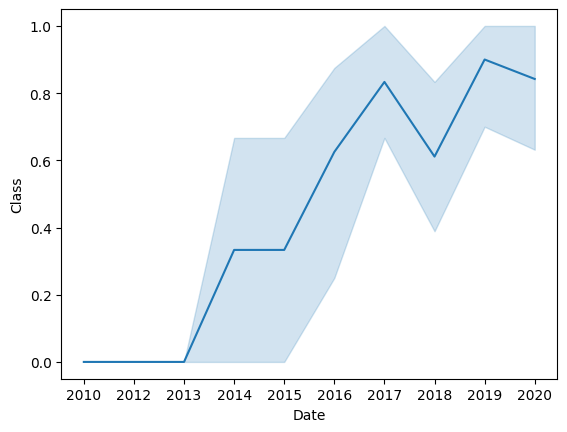

In [ ]:
sns.lineplot( data = df, x = 'Date', y = 'Class')

you can observe that the sucess rate since 2013 kept increasing till 2020

##Features Engineering
By now, you should obtain some preliminary insights about how each important variable would affect the success rate, we will select the features that will be used in success prediction in the future module.

In [ ]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6104.959412,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B1004


##TASK 7: Create dummy variables to categorical columns
Use the function get_dummies and features dataframe to apply OneHotEncoder to the column Orbits, LaunchSite, LandingPad, and Serial. Assign the value to the variable features_one_hot, display the results using the method head. Your result dataframe must include all features including the encoded ones.

In [ ]:
features_one_hot = pd.get_dummies(features, columns = ['Orbit', 'LaunchSite', 'LandingPad', 'Serial'])
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCAFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,6104.959412,1,False,False,False,1.0,0,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2,525.000000,1,False,False,False,1.0,0,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,3,677.000000,1,False,False,False,1.0,0,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4,500.000000,1,False,False,False,1.0,0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,5,3170.000000,1,False,False,False,1.0,0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


##TASK 8: Cast all numeric columns to float64
Now that our features_one_hot dataframe only contains numbers, cast the entire dataframe to variable type float64

In [ ]:
features_one_hot.astype('float64')

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCAFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6104.959412,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,1.0,1.0,1.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
86,87.0,15400.000000,3.0,1.0,1.0,1.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
87,88.0,15400.000000,6.0,1.0,1.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
features_one_hot.to_csv('dataset_part_3.csv', index=False)

In [ ]:
features_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 80 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   FlightNumber                         90 non-null     int64  
 1   PayloadMass                          90 non-null     float64
 2   Flights                              90 non-null     int64  
 3   GridFins                             90 non-null     bool   
 4   Reused                               90 non-null     bool   
 5   Legs                                 90 non-null     bool   
 6   Block                                90 non-null     float64
 7   ReusedCount                          90 non-null     int64  
 8   Orbit_ES-L1                          90 non-null     bool   
 9   Orbit_GEO                            90 non-null     bool   
 10  Orbit_GTO                            90 non-null     bool   
 11  Orbit_HEO                         

# Visualization with folium

In [ ]:
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

## Task 1: Mark all launch sites on a map

In [ ]:
# Download and read the `spacex_launch_geo.csv`
import requests
import io

URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv'
resp = requests.get(URL)
spacex_csv_file = io.BytesIO(resp.content)
spacex_df=pd.read_csv(spacex_csv_file)

First, let's try to add each site's location on a map using site's latitude and longitude coordinates

The following dataset with the name spacex_launch_geo.csv is an augmented dataset with latitude and longitude added for each site.

In [ ]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


Above coordinates are just plain numbers that can not give you any intuitive insights about where are those launch sites. If you are very good at geography, you can interpret those numbers directly in your mind. If not, that's fine too. Let's visualize those locations by pinning them on a map.

We first need to create a folium Map object, with an initial center location to be NASA Johnson Space Center at Houston, Texas.

In [ ]:
# Start location is NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

We could use folium.Circle to add a highlighted circle area with a text label on a specific coordinate. For example,

In [ ]:
# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

In [ ]:
spacex_df = df

In [ ]:
spacex_df.tail()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
85,86,2020,Falcon 9,15400.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,2,B1060,-80.603956,28.608058,1
86,87,2020,Falcon 9,15400.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,2,B1058,-80.603956,28.608058,1
87,88,2020,Falcon 9,15400.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,5,B1051,-80.603956,28.608058,1
88,89,2020,Falcon 9,15400.0,VLEO,CCAFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,2,B1060,-80.577366,28.561857,1
89,90,2020,Falcon 9,3681.0,MEO,CCAFS SLC 40,True ASDS,1,True,False,True,5e9e3032383ecb6bb234e7ca,5.0,0,B1062,-80.577366,28.561857,1


and you should find a small yellow circle near the city of Houston and you can zoom-in to see a larger circle.

Now, let's add a circle for each launch site in data frame launch_sites

TODO: Create and add folium.Circle and folium.Marker for each launch site on the site map

An example of folium.Circle:

folium.Circle(coordinate, radius=1000, color='#000000', fill=True).add_child(folium.Popup(...))

An example of folium.Marker:

folium.map.Marker(coordinate, icon=DivIcon(icon_size=(20,20),icon_anchor=(0,0), html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'label', ))

In [ ]:
# Loop through the launch_sites_df and add a circle and marker for each launch site
for index, site in launch_sites_df.iterrows():
    coordinate = [site['Lat'], site['Long']]
    # Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
    circle = folium.Circle(coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup(site['Launch Site']))
    # Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
    marker = folium.map.Marker(
        coordinate,
        # Create an icon as a text label
        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0),
            html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % site['Launch Site'],
            )
        )
    site_map.add_child(circle)
    site_map.add_child(marker)

# Display the map
site_map

# Task 2: Mark the success/failed launches for each site on the map

In [ ]:
# Create a map object
site_map = folium.Map(location=[spacex_df['Lat'].mean(), spacex_df['Long'].mean()], zoom_start=4)

# Create a MarkerCluster object
marker_cluster = MarkerCluster()

# Add marker_cluster to the map
site_map.add_child(marker_cluster)

# Add markers for each launch outcome
for index, row in spacex_df.iterrows():
    marker_color = 'green' if row['class'] == 1 else 'red'
    folium.Marker(
        location=[row['Lat'], row['Long']],
        popup=f"{row['Launch Site']} - Outcome: {'Success' if row['class'] == 1 else 'Failure'}",
        icon=folium.Icon(color=marker_color)
    ).add_to(marker_cluster)

# Display the map
site_map

KeyError: 'Lat'

# TASK 3: Calculate the distances between a launch site to its proximities

In [ ]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

In [ ]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [ ]:
# find coordinate of the closet coastline
coastline_lat = 28.56367
coastline_lon = -80.57163
launch_site_lat = 28.5624
launch_site_lon = -80.5772
distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)
distance_coastline

In [ ]:
distance_marker = folium.Marker(
    coordinate,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_coastline),
        )
    )

In [ ]:
coordinates = [[coastline_lat, coastline_lon], [launch_site_lat, launch_site_lon]]
lines=folium.PolyLine(locations=coordinates, weight=1)
site_map.add_child(lines)

In [ ]:
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

In [ ]:
import requests
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = requests.get(URL1)
text1 = io.BytesIO(resp1.content)
data = pd.read_csv(text1)

In [ ]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [ ]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = requests.get(URL2)
text2 = io.BytesIO(resp2.content)
X = pd.read_csv(text2)

In [ ]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCAFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.

#TASK 1
Create a NumPy array from the column Class in data, by applying the method to_numpy() then assign it to the variable Y,make sure the output is a Pandas series (only one bracket df['name of column']).

In [ ]:
y = data['Class'].to_numpy()
y = pd.DataFrame(y)
y

,0
0,0
1,0
2,0
3,0
4,0
...,...
85,1
86,1
87,1
88,1


In [ ]:
transform = preprocessing.StandardScaler()
X_scaled = transform.fit_transform(X)
# X.head() # head() is not available on a NumPy array

In [ ]:
X = pd.DataFrame(X_scaled, columns = X.columns)

#TASK 2
Standardize the data in X then reassign it to the variable X using the transform provided below.

In [ ]:
X_scaled_DF.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCAFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,-1.712912,-1.948145e-16,-0.653913,-1.575895,-0.97344,-0.106,-0.106,-0.654654,-0.106,-0.551677,3.443420,-0.185695,-0.333333,-0.106,-0.242536,-0.429198,0.797724,-0.568796,-0.410891,-0.410891,-0.150756,-0.797724,-0.150756,-0.392232,9.433981,-0.106000,-0.106000,-0.106000,-0.106000,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.106,-0.150756,-0.150756,-0.150756,-0.106,-0.106,-0.106,-0.150756,-0.215666,-0.185695,-0.215666,-0.267261,-0.106,-0.242536,-0.106,-0.215666,-0.185695,-0.215666,-0.185695,-0.106,1.870829,-1.870829,0.835532,-0.835532,1.933091,-1.933091
1,-1.674419,-1.195232e+00,-0.653913,-1.575895,-0.97344,-0.106,-0.106,-0.654654,-0.106,-0.551677,3.443420,-0.185695,-0.333333,-0.106,-0.242536,-0.429198,0.797724,-0.568796,-0.410891,-0.410891,-0.150756,-0.797724,-0.150756,-0.392232,-0.106000,9.433981,-0.106000,-0.106000,-0.106000,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.106,-0.150756,-0.150756,-0.150756,-0.106,-0.106,-0.106,-0.150756,-0.215666,-0.185695,-0.215666,-0.267261,-0.106,-0.242536,-0.106,-0.215666,-0.185695,-0.215666,-0.185695,-0.106,1.870829,-1.870829,0.835532,-0.835532,1.933091,-1.933091
2,-1.635927,-1.162673e+00,-0.653913,-1.575895,-0.97344,-0.106,-0.106,-0.654654,-0.106,1.812654,-0.290409,-0.185695,-0.333333,-0.106,-0.242536,-0.429198,0.797724,-0.568796,-0.410891,-0.410891,-0.150756,-0.797724,-0.150756,-0.392232,-0.106000,-0.106000,9.433981,-0.106000,-0.106000,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.106,-0.150756,-0.150756,-0.150756,-0.106,-0.106,-0.106,-0.150756,-0.215666,-0.185695,-0.215666,-0.267261,-0.106,-0.242536,-0.106,-0.215666,-0.185695,-0.215666,-0.185695,-0.106,1.870829,-1.870829,0.835532,-0.835532,1.933091,-1.933091
3,-1.597434,-1.200587e+00,-0.653913,-1.575895,-0.97344,-0.106,-0.106,-0.654654,-0.106,-0.551677,-0.290409,-0.185695,3.000000,-0.106,-0.242536,-0.429198,-1.253566,-0.568796,2.433737,-0.410891,-0.150756,-0.797724,-0.150756,-0.392232,-0.106000,-0.106000,-0.106000,9.433981,-0.106000,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.106,-0.106,-0.106,-0.106,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.150756,-0.150756,-0.106,-0.106,-0.150756,-0.150756,-0.150756,-0.106,-0.106,-0.106,-0.150756,-0.215666,-0.185695,-0.215666,-0.267261,-0.106,-0.242536,-0.106,-0.21566

#TASK 3
Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to 0.2 and random_state to 2. The training data and test data should be assigned to the following labels.

X_train, X_test, Y_train, Y_test

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
Y_test.shape

(18, 1)

#TASK 4
Create a logistic regression object then create a GridSearchCV object logreg_cv with cv = 10. Fit the object to find the best parameters from the dictionary parameters.

In [ ]:
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [ ]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [ ]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()

In [ ]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


In [ ]:
print("Test set accuracy: ", logreg_cv.score(X_test, Y_test))

Test set accuracy:  0.8333333333333334


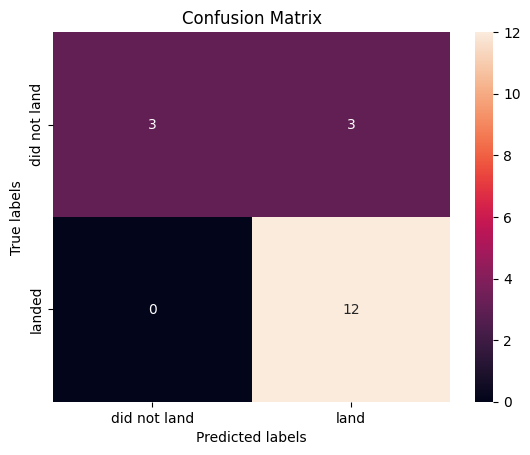

In [ ]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [ ]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

svm_cv = GridSearchCV(svm, parameters, cv=10)

In [ ]:
svm_cv.fit(X_train, Y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [ ]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': np.float64(1.0), 'gamma': np.float64(0.03162277660168379), 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


In [ ]:
print("Test set accuracy: ", svm_cv.score(X_test, Y_test))

Test set accuracy:  0.8333333333333334


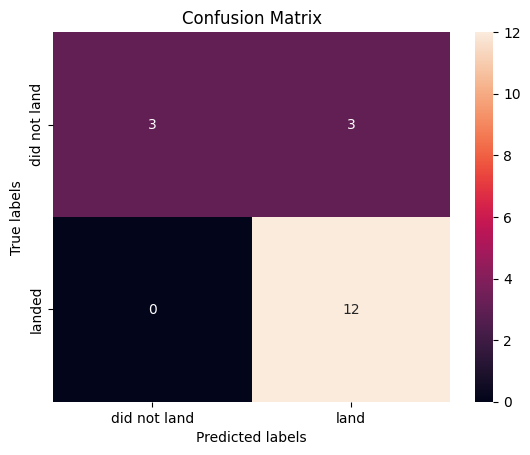

In [ ]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [ ]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, parameters, cv =10)

In [ ]:
tree_cv.fit(X_train, Y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/u

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [ ]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
accuracy : 0.875


In [ ]:
tree_cv.score(X_test, Y_test)

0.8333333333333334

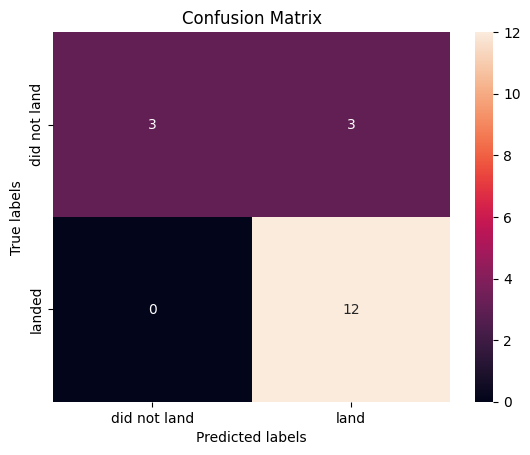

In [ ]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [ ]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

knn_cv = GridSearchCV(KNN, parameters, cv=10)


In [ ]:
knn_cv.fit(X_train, Y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [ ]:
 print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


In [ ]:
knn_cv.score(X_test, Y_test)

0.8333333333333334

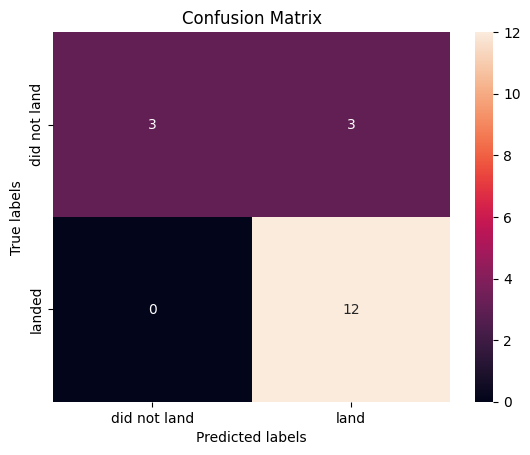

In [ ]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [ ]:
bar_data = [knn_cv.best_score_,tree_cv.best_score_, svm_cv.best_score_, logreg_cv.best_score_]
bar_data

[np.float64(0.8482142857142858),
 np.float64(0.875),
 np.float64(0.8482142857142856),
 np.float64(0.8464285714285713)]

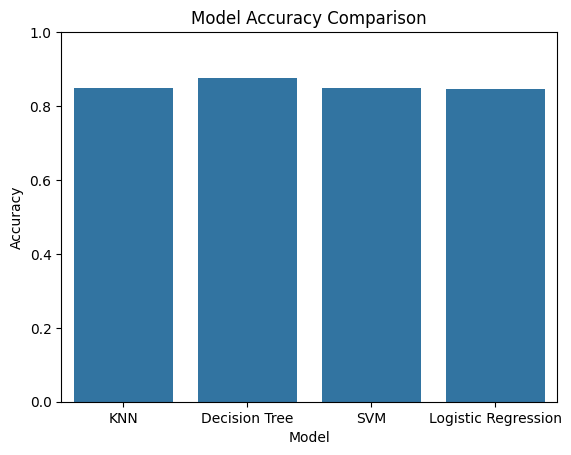

In [ ]:
model_names = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
accuracy_scores = [knn_cv.best_score_,tree_cv.best_score_, svm_cv.best_score_, logreg_cv.best_score_]

accuracy_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_scores
})

sns.barplot(x='Model', y='Accuracy', data=accuracy_df)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1) # Set y-axis limit from 0 to 1 for accuracy
plt.show()

In [ ]:
# The best model is The tree classifier